In [1]:
import numpy as np
import nltk
import re
from time import time
from gensim import corpora, models, similarities
from itertools import chain
from _datetime import datetime
from lxml import etree
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from math import log
from pprint import pprint as pp
from string import punctuation
from collections import defaultdict, deque
import pandas as pd
import numpy

**Для чтения исходных данных Excel**

In [2]:
def read_data(filename):
    """Reads the given file and creates a generator object returning one line at a time split by tabulation"""
    data = pd.read_excel(filename)
    return data

**Препроцессинг**

In [3]:
# with open('.\expectations_meter\english_stopwords.txt', 'r', encoding='utf-8') as f:
with open('.\english_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [word.strip() for word in f.readlines()]

lemmatizer = WordNetLemmatizer()

numbers = re.compile('[0-9]')
punctuation += '\n—–- «»\'\"'

def lemmatize(text):
    return [lemmatizer.lemmatize(word).lower() for word in nltk.word_tokenize(text) 
            if word not in stopwords + list(punctuation)
            and word not in ["''", ' ', '``', '', "'s"]
            ]

def preprocess(text):
    # sentences = nltk.sent_tokenize(text)
    tokens = lemmatize(text.replace('\n', ' '))
    # [tokens.extend(lemmatize(sent)) for sent in sentences]
    return tokens

**Для получения токенизированных и лемматизированных данных и дат из корпуса**

In [4]:
def get_corpus(filename):
    # data = read_data(filename).iloc[:1000]
    data = read_data(filename)
    dates = data['datetime']
    # bodies = [preprocess(text) for text in list(data['body']) if not pd.isnull(text)]
    # titles = [preprocess(text) for text in list(data['title']) if not pd.isnull(text)]
    bodies = []
    for index, (title, body, author, datetime) in data.iterrows():
        if not pd.isnull(body):
            bodies.append(preprocess(body))
    return bodies, dates

**Функции для поиска ключевых слов в тексте **

In [5]:
def mark_text(words, text):
    for word in words:
        text = text.replace(word, '[<' + word + '>]')
    return text

def search_words(keywords, text):
    tokens = preprocess(text)
    keywords = set(list(chain(*preprocess(keywords))))
    intersection = list(keywords.intersection(set(list(chain(*tokens)))))
    if intersection:
        return intersection, mark_text(intersection, text), tokens

**Список всех продуктов**

Считываем список всех продуктов Apple из стороннего файла. Создаем список из tuples. Убираем все упоминания числа гигабайт в моделях, а так же типов сотовой связи, и времени выхода в году

In [88]:
def make_product_tuple(product_full_name):
    name_cleaned = ''.join([char for char in product_full_name.lower() if not char in '()\'"&']).split()
    parts_to_remove = ['gb', '+', 'with', 'wcdma', 'cdma', 'gsm', '16', '32', '64', '128']
    name_cleaned = tuple([re.sub('([0-9])(rd|st|nd|th)', '\\1', word) for word in name_cleaned if not word in parts_to_remove])
    return name_cleaned

def make_product_regex(product_full_name, min_req):
    product_tuple = make_product_tuple(product_full_name)
    product_regex = ''
    for i in range(len(product_tuple)):
        if i < min_req:
            product_regex += ' ({})'.format(product_tuple[i])
        else:
            product_regex += ' *({})?'.format(product_tuple[i])
    return re.compile(product_regex.strip())

def read_product_list(product_list_file):
    models = defaultdict(lambda: defaultdict(list))
    product_list = read_data(product_list_file)
    for i, (year, launched, date_launched, model_full, keywords, inter_req, model_group, family, discontinued) in product_list.iterrows():
        product = make_product_regex(keywords, inter_req)
        model_group = ' '.join(model_group.split())
        if not product in models[year][model_group]:
            models[year][model_group].append((product, inter_req))
    return models

# reg=make_product_regex('MacBook Air 2012', 2)
# print(reg)
# result = reg.findall(' '.join(list(preprocess(' the new MacBook Air 2011 is about to be launched'))))
# result
# product_list = read_product_list('.\expectations_meter\DATA\Apple_produt_list_devices_only.xlsx')
product_list = read_product_list('.\DATA\Apple_produt_list_devices_only.xlsx')
product_list

defaultdict(<function __main__.read_product_list.<locals>.<lambda>>,
            {2000: defaultdict(list,
                         {'Power Mac G4 Cube': [(re.compile(r'(power) (mac) (g4) *(cube)?',
                            re.UNICODE),
                            3)],
                          'PowerBook ("Pismo")': [(re.compile(r'(powerbook) (pismo)',
                            re.UNICODE),
                            3)],
                          'iBook (FireWire)': [(re.compile(r'(ibook) *(firewire)?',
                            re.UNICODE),
                            1)]}),
             2001: defaultdict(list,
                         {'Power Mac G4 Quicksilver': [(re.compile(r'(power) (mac) (g4) *(quicksilver)?',
                            re.UNICODE),
                            3)],
                          'PowerBook G4 Titanium': [(re.compile(r'(powerbook) (g4) (titanium)',
                            re.UNICODE),
                            3)],
                     

**Поиск упоминаний продуктов из списка в корпусе**.

Проходим по каждому тексту окном в 7 токенов. Если в них встречается пересечние с любым из продуктов аорзмером 2 и больше слов, то считаем, что продукт упоминается, и добавляем его в список упоминаний для данного продукта и данной даты

In [63]:
def search_products(tokenized_text, window, product_list, year):
    product_mentions =  set()
    for i in range(window, len(tokenized_text)):
        current_window = tokenized_text[i-window:i]
        intersections = {}
        for y in range(year, year+2):
            for product, keywords in product_list[y].items():
                current_intersections = []
                for keyword, inter_req in keywords:
                    reduced_window = set(current_window[:inter_req+1])
                    intersection = reduced_window.intersection(set(keyword)) 
                    if intersection:
                        print('win:', reduced_window, 'int:', intersection, 'key:', keyword, 'pr:', product)  
                    if len(intersection) >= inter_req and not (len(intersection) == 1 and list(intersection)[0].isnumeric()):
                        current_intersections.append(intersection)
                if len(current_intersections) > 0:
#                     print(current_intersections)
                    intersections[product] = tuple(max(current_intersections, key=lambda x: len(x)))
        if len(intersections) > 0:
            product_mentions.add(max(intersections.items(), key=lambda x: (x[1]))[0])
    return product_mentions

text = preprocess(""""
"Product: For the past week I’ve been using the Justin Case (Ultra-Slim) Rechargeable Power Case for the iPad. Essentially, the case is a folio-style cover for the iPad 2, 3, or 4 that includes a massive 11,600 mAh battery built into the cover which you can use to charge your iPad, iPhone, iPod, or pretty much any other portable device. The case also functions as a stand for your iPad.


(adsbygoogle = window.adsbygoogle || []).push({});
Tweetbot For iOS
Performance/Features: The Justin Case performs two functions, and thus needs to be evaluated from multiple angles. First, as an iPad case. The product is made of a soft, synthetic leather material. While it doesn’t feel exceptionally premium, it doesn’t feel cheap or tacky either. The material makes it easily grippable and secure in your hand, while not collecting dust and dirt like some silicone cases will. The build quality follows suit and is fairly average. While I didn’t experience any issues in my testing, some of the seams aren’t particularly snug and I can see how extended wear and usage could cause some seams to separate over time, especially on the rear stand. That said, I do really like how the stand functions, securing to the back with magnets embedded in the case, and a support connecting the edge of the stand to the back of the case, making the stand extra stable. I had no problem accessing any of the iPad’s ports in the case, and a handy loop and flap on the front keeps the battery cover securely in place for travel.

As a battery, I was extremely impressed with the Justin Case. The cover of the case is dedicated completely to the battery, making it rigid and strong. Unfortunately, this also adds quite a bit of heft and thickness to the case when closed, almost doubling both. For perspective, held side by side, my iPad 3 in the Justin Case felt heftier than an 11” MacBook Air. However, I didn’t mind the tradeoffs, as the benefits greatly outweighed the drawbacks here. Innovative Technology, the makers of the Justin Case, claim that you can charge an iPhone 7 times off a single charge of the case’s battery, and an iPad 3 or 4 close to once. In my testing, I found these claims to be pretty accurate. I was able to get through the majority of a week using a single charge of the Justin Case, the charge it came with out of the box, as the sole power source for my iPhone. The case finally gave out during my 6th charge, slightly under the 7 charge number suggested by the manufacturer. I attribute this discrepancy due to the fact that while charging, I often used my iPhone plugged in, and the device was constantly receiving notifications in the background, eating up additional power. Similarly, I was able to charge my iPad 3 to about 70% off of one charge of the Justin Case, while it was turned on and receiving notifications.

Although I had only an iPad and iPhone to test with the case, you can charge many other devices like Kindles, Samsung and Blackberry phones, and more, because the case uses a USB port in the cover to interface with your devices, not connecting directly to the iPad in the case. To charge the case, a micro USB cable and AC adapter are included with the product, and a micro USB port resides right next its full-sized counterpart for charging purposes. A series of four blue LED lights are present on the inside of the cover and indicate the charge status of the case, with 1 being almost empty and 4 lights meaning the case is nearly or already full. A small button next to the lights will turn on the LEDs to display the charge status briefly and also turns on the case for charging. Innovative Technology claims the battery takes about 14 hours to fully charge when plugged into the wall due to its huge capacity, and the claim seemed to ring true. Plugging the case in at 1pm, I found that I needed to wait until the morning for it to be completely full.
The only problem that I encountered with the product during use is that charging seemed to inexplicably stop right before my iPhone was full. Often times when I’d plug my phone in before going to sleep, I’d wake up in the morning to find it sitting at about 93%, and not charging, as if the case automatically shuts off before the device is full. Whether this is an issue or a feature I’m not sure of.

Why: The Justin Case is a great product for those who frequently travel or can’t always get to an outlet to charge their devices. The high capacity battery is ideal for being off the grid for long periods of time. With light use, you could probably get over a week’s worth of battery charges for your iPhone out of a single charge of the case. That said, the Justin Case adds a considerable amount of bulk to your iPad, so you should think twice if you’re looking for a lightweight case.
Price: The Justin Case retails for $69.99 but can be found slightly cheaper here on Amazon. Innovative Technology also offers many other variations of the Justin Case on its website."
"

""")
# print(text)
search_products(text, 6, product_list, 2013)

win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'air') pr: iPad Air
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'air') pr: iPad Air
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '2') pr: iPad Mini 2
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '2') pr: iPad Mini 2
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '2') pr: iPad Mini 2
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'air', '2') pr: iPad Air 2
win: {'power', 'case', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '3') pr: iPad Mini 3
win: {'case', 'essentially', 'ipad'} int: {'ipad'} key: ('ipad', 'air') pr: iPad Air
win: {'case', 'essentially', 'ipad'} int: {'ipad'} key: ('ipad', 'air') pr: iPad Air
win: {'case', 'essentially', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '2') pr: iPad Mini 2
win: {'case', 'essentially', 'ipad'} int: {'ipad'} key: ('ipad', 'mini', '2') pr: iPad Mini 2
win: {'case', 'essentially', 'ipad'} int: {'ip

{'MacBook Air (Early 2014)', 'iPad Mini 2', 'iPad Mini 3', 'iPhone 6'}

In [25]:
def find_mentions(dates, texts):
    mentions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    parsed_dates = parse_dates(dates)
    for date, (id, text) in zip(parsed_dates, enumerate(texts)):
        # year = re.search('20[01][0-9]', date).group(0)
        year = date.year
        month = date.month
        year_month = datetime(year, month, 1).date()
        # print(year_month)
        # str_date = str(date)
        products_mentioned = search_products(text, 4, product_list, int(str(year)))
        # print(date, year, products_mentioned)
        for product in products_mentioned:
            product_name = ' '.join(list(product))
            # mentions[product_name][date]['number'] += 1
            if 'text_ids' in  mentions[product_name][year_month]:
                if id not in mentions[product_name][year_month]['text_ids']:
                    mentions[product_name][year_month]['text_ids'].append(id)
                    mentions[product_name][year_month]['number'] += 1
            else:
                mentions[product_name][year_month]['text_ids'] = [id]
                mentions[product_name][year_month]['number'] += 1
    return mentions

**Парсим даты**

In [11]:
from datetime import datetime

def parse_date(date_string):
    # date_only = date_string[:10]
    # '2009-01-01 08:25:07'
    # 2012-01-17T17:57:00-05:00
    # Friday November 10, 2006 10:49 pm PST
    if 'T' not in date_string:
        date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
    elif 'pst' in date_string.lower() or 'pdt' in date_string.lower():
        date = datetime.strptime(date_string[:-4], '%A %B %d, %Y %H:%M %p').date()
    else:
        date = datetime.strptime(date_string[:-6], '%Y-%m-%dT%H:%M:%S').date() 
    return date
print(parse_date('Friday November 10, 2006 10:49 pm PST'))

def parse_dates(dates):
    return [parse_date(date) for date in dates]

2006-11-10


**Визуализация**

Визуализируем распределение упоминаний продуктов по датам

In [12]:
import matplotlib.pyplot as plt
def plot_mentions(mentions, dates):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    new_dates = parse_dates(dates)
    legend = []
    for product in mentions:
        if 'macbook pro' in product:
            ment_numbers = [mentions[product][datetime(date.year, date.month, 1).date()]['number'] 
                            if datetime(date.year, date.month, 1).date() in mentions[product] else 0 for date in new_dates]
            plt.plot(new_dates, ment_numbers)
            legend.append(product)
    plt.legend(legend)
    plt.show()

**Собираем все вместе**

In [14]:
product_list = read_product_list('.\expectations_meter\DATA\Apple_produt_list_devices_only.xlsx')
product_list[2009]['MacBook Pro (4th gen) 2016']

[]

In [18]:
app_ins_bodies, app_ins_dates = get_corpus('.\expectations_meter\DATA\AppleInsider.xlsx')
# nfm_bodies, nfm_dates = get_corpus('.\expectations_meter\DATA\\NineToFiveMac.xlsx')
# mcr_bodies, mcr_dates = get_corpus('.\expectations_meter\DATA\\MacRummors.xlsx')

In [21]:
with open('.\expectations_meter\DATA\\MacRummors_tokenized.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(mcr_bodies))

In [53]:
# parsed_app_ins_dates = parse_dates(app_ins_dates)

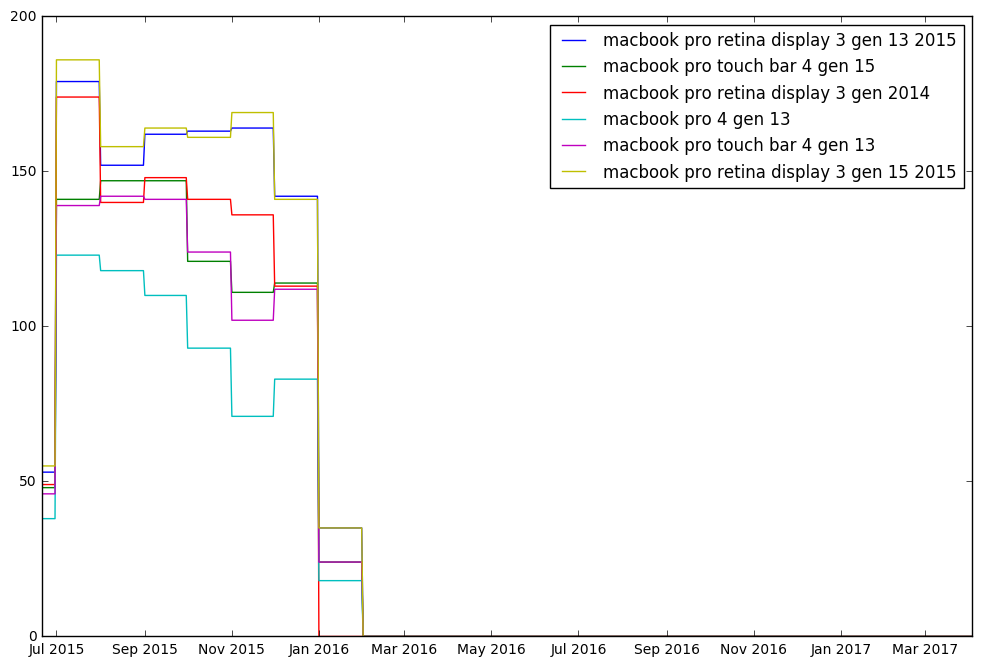

In [65]:
appins_mentions = find_mentions(app_ins_dates[20000:], app_ins_bodies[20000:])
plot_mentions(appins_mentions, app_ins_dates[20000:])

# mcr_mentions = find_mentions(mcr_dates[20000:], mcr_bodies[20000:])
# plot_mentions(mcr_mentions, mcr_dates[20000:])

# nfm_mentions = find_mentions(nfm_dates[8000:], nfm_bodies[8000:])
# nfm_mentions
# plot_mentions(nfm_mentions, nfm_dates[8000:])